In [1]:
# To force TensorFlow to use CPU only
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm.auto import tqdm  # For progress bars

In [3]:
# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Check for GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available. Using CPU.")

TensorFlow version: 2.18.0
GPU is not available. Using CPU.


In [4]:
# Load the dataset
df = pd.read_csv('dataset.csv')

# Preview the dataset
print(df.head())

                                            headline  label
0       cock  suck before you piss around on my work     -1
1  you are  gay or antisemmitian archangel white ...     -1
2            fuck your filthy mother in the ass  dry     -1
3  get fuck  ed up  get fuck  ed up got a drink t...     -1
4  stupid peace of  shit  stop deleting my stuff ...     -1


In [5]:
# Map labels: -1 -> 0 (Bullying), 0 -> 1 (Neutral), 1 -> 2 (Positive)
label_mapping = {-1: 0, 0: 1, 1: 2}
df['label'] = df['label'].map(label_mapping)

# Verify the mapping
print(df['label'].value_counts())

label
0    11661
1     6487
Name: count, dtype: int64


In [6]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]+', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply to the dataset
df['headline'] = df['headline'].apply(clean_text)

In [7]:
# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['headline'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

print(f"Number of training samples: {len(train_texts)}")
print(f"Number of validation samples: {len(val_texts)}")

Number of training samples: 14518
Number of validation samples: 3630


In [8]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the inputs
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [10]:
def create_tf_dataset(encodings, labels):
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']

     # converts Python lists into TensorFlow tensors, which are required for model training.

    # Convert lists to tensors
    input_ids = tf.constant(input_ids)
    attention_mask = tf.constant(attention_mask)
    labels = tf.constant(labels)
    
    dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': input_ids, 'attention_mask': attention_mask},
        labels
    ))
    return dataset

# Create the TensorFlow datasets
train_dataset = create_tf_dataset(train_encodings, train_labels)
val_dataset = create_tf_dataset(val_encodings, val_labels)

In [11]:
batch_size = 16

train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [12]:
# Load BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Define optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 3  # You can adjust this

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

In [17]:
# Get predictions
val_preds = []  # Stores model's predicted labels
val_true = []   # Stores actual labels from validation data

for batch in tqdm(val_dataset, desc="Evaluating"):
    inputs, labels = batch
    logits = model(inputs, training=False).logits
    predictions = tf.argmax(logits, axis=-1)
    val_preds.extend(predictions.numpy())
    val_true.extend(labels.numpy())

# Calculate accuracy
val_accuracy = accuracy_score(val_true, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")



Evaluating: 100%|████████████████████████████████████████████████████████████████████| 227/227 [18:48<00:00,  4.97s/it]

Validation Accuracy: 0.95


In [4]:
# Define labels and corresponding class names
labels = [0, 1]  # These are your class indices
label_names = ['Bullying', 'Non-Bullying']

# Generate the classification report with specified labels
print("\nClassification Report:")
print(classification_report(val_true, val_preds, labels=labels, target_names=label_names))


Classification Report:


NameError: name 'val_true' is not defined

In [18]:
# Save the trained model
model.save_pretrained('bullying_detection_tf_model')

# Save the tokenizer
tokenizer.save_pretrained('bullying_detection_tf_model')

('bullying_detection_tf_model\\tokenizer_config.json',
 'bullying_detection_tf_model\\special_tokens_map.json',
 'bullying_detection_tf_model\\vocab.txt',
 'bullying_detection_tf_model\\added_tokens.json')

In [2]:
def predict(text):
    # Tokenize the input text
    encoding = tokenizer(text, return_tensors='tf', truncation=True, padding=True, max_length=128)
    
    # Make prediction
    logits = model(encoding.data).logits
    prediction = tf.argmax(logits, axis=1).numpy()[0]
    
    # Map prediction to label
    label_map = {0: 'Bullying', 1: 'Neutral', 2: 'Positive'}
    return label_map[prediction]

In [4]:
# Example texts
texts = [
    "I hate you so much!",
    "You son of a bitch",
    "You did a fantastic job on your presentation!"
]

# Make predictions
for text in texts:
    label = predict(text)
    print(f"Text: {text}\nPrediction: {label}\n")

NameError: name 'tokenizer' is not defined

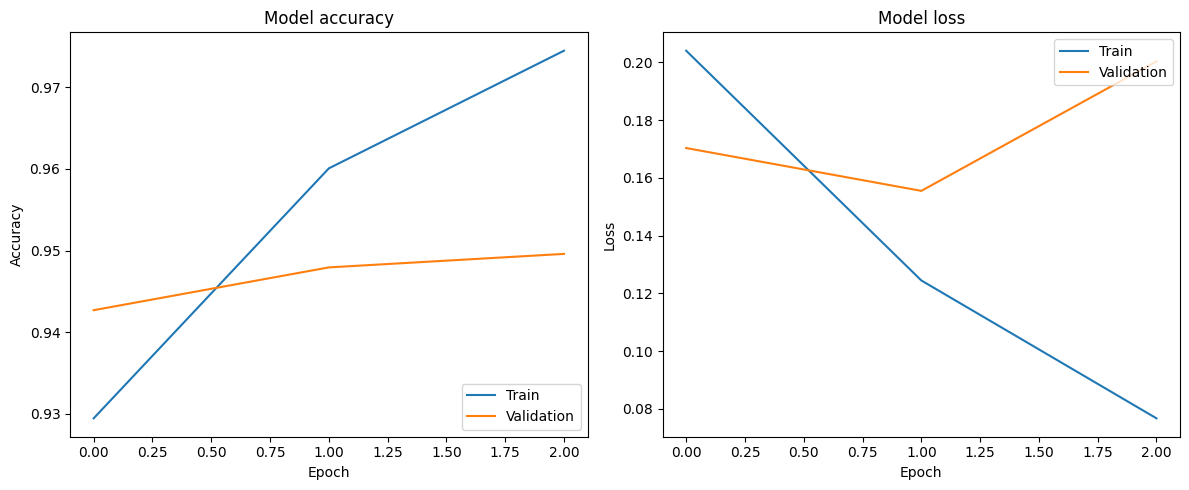

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [5]:
# ------------------------ Prediction Functions ------------------------

# Load the BERT model and tokenizer
import tensorflow as tf 
from tensorflow import keras
from transformers import BertTokenizer, TFBertForSequenceClassification
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bullying_detection_tf_model')

# Load the model
model = TFBertForSequenceClassification.from_pretrained('bullying_detection_tf_model')
# Function to predict text input
def predict_text(text):
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='tf'
    )

    outputs = model(encoding)
    logits = outputs.logits
    probs = tf.nn.softmax(logits, axis=1)
    pred = tf.argmax(probs, axis=1).numpy()[0]
    label_map = {0: 'Bullying', 1: 'Non-Bullying'}
    print(f"Prediction: {label_map[pred]} ")



All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bullying_detection_tf_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [6]:
predict_text("good boy suck")

Prediction: Non-Bullying 
